In this exercise you will train a CNN on the FULL Cats-v-dogs dataset. This will require you doing a lot of data preprocessing because the dataset isn't split into training and validation for you.

In [1]:
import os
import zipfile
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile

# Data Preparation

## 1. Download and extract the data

In [2]:
!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()


--2020-12-07 07:38:19--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.219.32.233, 2600:1417:76:293::e59, 2600:1417:76:2aa::e59
Connecting to download.microsoft.com (download.microsoft.com)|23.219.32.233|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.68M   165MB/s    in 4.8s    

2020-12-07 07:38:24 (165 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824894548/824894548]



In [3]:
print(len(os.listdir('/tmp/PetImages/Cat/')))
print(len(os.listdir('/tmp/PetImages/Dog/')))


12501
12501


## 2. Create directories for train-test dataset

In [4]:
try:
  # we have to build this from parent to child directories
  os.mkdir('/tmp/cats-v-dogs')

  os.mkdir('/tmp/cats-v-dogs/training')
  os.mkdir('/tmp/cats-v-dogs/testing')

  os.mkdir('/tmp/cats-v-dogs/training/cats')
  os.mkdir('/tmp/cats-v-dogs/training/dogs')

  os.mkdir('/tmp/cats-v-dogs/testing/cats')
  os.mkdir('/tmp/cats-v-dogs/testing/dogs')

except OSError:
  pass

## 3. Split Source data to Train-Test data

In [5]:
def split_data(SOURCE_DIR, TRAINING_DIR, TESTING_DIR, SPLIT_SIZE):
  fnames_raw = os.listdir(SOURCE_DIR)
  fnames_shuffled = random.sample(fnames_raw, len(fnames_raw))

  # clean
  # fget uncorrupted data only
  fnames = []
  for fname in fnames_shuffled:
    if os.path.getsize(SOURCE_DIR +fname) !=0:
      fnames.append(fname)
  
  # split fnames
  train_fnames = fnames[:int(len(fnames)*SPLIT_SIZE)]
  test_fnames = fnames[int(len(fnames)*SPLIT_SIZE):]

  # transfer via copying files
  for fname in train_fnames:
    copyfile(SOURCE_DIR + fname, TRAINING_DIR + fname)

  for fname in test_fnames:
    copyfile(SOURCE_DIR + fname, TESTING_DIR + fname)

split_size = 0.9

CAT_SOURCE_DIR = '/tmp/PetImages/Cat/'
CAT_TRAINING_DIR = '/tmp/cats-v-dogs/training/cats/'
CAT_TESTING_DIR = '/tmp/cats-v-dogs/testing/cats/'

DOG_SOURCE_DIR = '/tmp/PetImages/Dog/' 
DOG_TRAINING_DIR = '/tmp/cats-v-dogs/training/dogs/'
DOG_TESTING_DIR = '/tmp/cats-v-dogs/testing/dogs/'

split_data(CAT_SOURCE_DIR, CAT_TRAINING_DIR, CAT_TESTING_DIR, split_size)
split_data(DOG_SOURCE_DIR, DOG_TRAINING_DIR, DOG_TESTING_DIR, split_size)

In [6]:
print(len(os.listdir('/tmp/cats-v-dogs/training/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/training/dogs/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/dogs/')))

11250
11250
1250
1250


## 4. Train and Valid ImageDataGenerator

In [7]:
TRAIN_DIR = "/tmp/cats-v-dogs/training/"
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR, 
    batch_size = 10,
    target_size = (300, 300),
    class_mode = "binary"
)

VALID_DIR = "/tmp/cats-v-dogs/testing/"
valid_datagen = ImageDataGenerator(rescale=1./255)
valid_generator = valid_datagen.flow_from_directory(
    VALID_DIR,
    batch_size = 10,
    target_size = (300, 300),
    class_mode = "binary"
)

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


# Model

## 1. Build the Model

In [8]:
model = keras.models.Sequential([
                                 keras.layers.Conv2D(16, (3,3), activation="relu", input_shape=(300,300, 3)),
                                 keras.layers.MaxPooling2D(2,2),
                                 keras.layers.Conv2D(32, (3,3), activation="relu"),
                                 keras.layers.MaxPooling2D(2,2),
                                 keras.layers.Conv2D(64, (3,3), activation="relu"),
                                 keras.layers.MaxPooling2D(2,2),
                                 keras.layers.Conv2D(64, (3,3), activation="relu"),
                                 keras.layers.MaxPooling2D(2,2),
                                 keras.layers.Conv2D(64, (3,3), activation="relu"),
                                 keras.layers.MaxPooling2D(2,2),

                                 keras.layers.Flatten(),
                                 keras.layers.Dense(512, activation = "relu"),
                                 keras.layers.Dense(128, activation="relu"),
                                 keras.layers.Dense(128, activation="relu"),
                                 keras.layers.Dense(64, activation="relu"),
                                 keras.layers.Dense(1, activation="sigmoid"),
])

## 2. Compile the Model

In [9]:
model.compile(loss = "binary_crossentropy", optimizer = RMSprop(lr=0.001), metrics=["accuracy"])

## 3. Fit the model

In [10]:
history = model.fit(
    train_generator,
    epochs = 15,
    verbose =2,
    validation_data = valid_generator
)

Epoch 1/15


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

2250/2250 - 457s - loss: 0.6722 - accuracy: 0.5966 - val_loss: 0.5734 - val_accuracy: 0.7436
Epoch 2/15
2250/2250 - 445s - loss: 0.6162 - accuracy: 0.6785 - val_loss: 0.5954 - val_accuracy: 0.7356
Epoch 3/15
2250/2250 - 440s - loss: 0.5992 - accuracy: 0.6998 - val_loss: 0.4779 - val_accuracy: 0.7660
Epoch 4/15
2250/2250 - 440s - loss: 0.5836 - accuracy: 0.7214 - val_loss: 0.4626 - val_accuracy: 0.7988
Epoch 5/15
2250/2250 - 441s - loss: 0.5755 - accuracy: 0.7268 - val_loss: 0.4603 - val_accuracy: 0.8076
Epoch 6/15
2250/2250 - 441s - loss: 0.5700 - accuracy: 0.7329 - val_loss: 0.4945 - val_accuracy: 0.7636
Epoch 7/15
2250/2250 - 444s - loss: 0.5725 - accuracy: 0.7374 - val_loss: 0.4843 - val_accuracy: 0.8096
Epoch 8/15
2250/2250 - 445s - loss: 0.5983 - accuracy: 0.7200 - val_loss: 0.5249 - val_accuracy: 0.7604
Epoch 9/15
2250/2250 - 453s - loss: 0.5935 - accuracy: 0.7234 - val_loss: 0.9486 - val_accuracy: 0.7856
Epoch 10/15
2250/2250 - 465s - loss: 0.6886 - accuracy: 0.7217 - val_loss: 

## 4. Plot loss and accuracy

In [11]:
type(history)

tensorflow.python.keras.callbacks.History

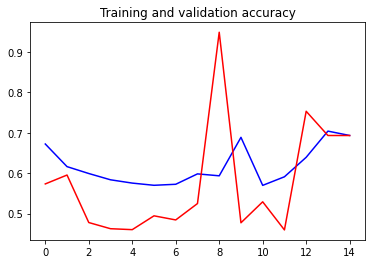

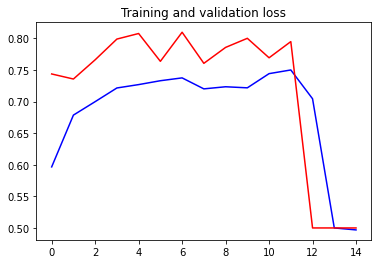

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt



train_loss = history.history['loss']
val_loss = history.history['val_loss']

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(len(train_acc))

plt.plot(epochs, train_loss, color="b", label="train_loss")
plt.plot(epochs, val_loss, color="r", label="valid_loss")
plt.title('Training and validation accuracy')
plt.figure()

plt.plot(epochs, train_acc, color="b",label="train_acc")
plt.plot(epochs, val_acc, color="r",label="valid_acc")
plt.title('Training and validation loss')

plt.show()